#Hopfield Network
Asynchronous update, since this is more biologically plausible. Weight symmetry

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Hopfield_Network:
  def __init__(self, N, epsilon):
    """Arguments:
          self: instance of class
          N: number of nodes
          epsilon: training factor
      Returns:
          Nothing"""
    self.N = N
    self.state = np.ones(N) # state vector

    self.weights = np.random.choice([-1,1], (N, N)) # create random matrix of -1, 1
    self.epsilon = N # default
    self.energy = self.Hopfield_Network_compute_energy() # energy of network
    # make self.weights symmetric
    for row in range(self.N):
      for col in range(row, self.N):
        self.weights[col][row] = self.weights[row][col]
  
  def Hopfield_Network_train_memory_single(self, p_vector):
    """Arguments:
          self: instance of class
          p_vector: memory to learn (np column vector)
      Returns:
          Nothing"""
    self.weights = self.weights + self.epsilon * (p_vector * np.transpose(p_vector) - np.identity(self.N)) # subtract identity to have zero self weights
    
  def Hopfield_Network_train_memory_collection(self, p_matrix):
    """Arguments:
          self: instance of class
          p_matrix: matrix of memories, each memory is column vector (can be single memory)
        Returns:
          Nothing"""
    self.weights = self.epsilon * (p_matrix.dot(np.transpose(p_matrix)) - np.identity(self.N)) # should I have identity
  
  
  def Hopfield_Network_set_state(self, state_initial):
    """Arguments:
          self: instance of class
          state_initial: initial states
        Returns:
          Nothing"""
    self.state = np.copy(state_initial)

  def Hopfield_Network_evolve_one_step(self):
    """Arguments:
          self: instance of class
        Returns:
          Nothing"""
    node_index = np.random.randint(0, self.N)
   # print("Index", node_index)
    node_energy = self.weights[node_index].dot(self.state)
    #print("node energy", node_energy)
    # update
    if node_energy >= 0:
      self.state[node_index] = 1
    else:
      self.state[node_index] = -1
  
  def Hopfield_Network_evolve_fully_async(self):
    """Arguments:
          self: instance of class
        Returns:
          Nothing"""

    # evolve one step
    energy_prev = self.energy
    self.Hopfield_Network_evolve_one_step()
    self.energy = self.Hopfield_Network_compute_energy()
    count = 0 # number of times there is no decrease in energy
    while count < 3 * self.N: # could compare state vector instead of energy
      if self.energy == energy_prev:
        count = count + 1
      else:
        count = 0
      energy_prev = self.energy
      self.Hopfield_Network_evolve_one_step()
      self.energy = self.Hopfield_Network_compute_energy()


  
  def Hopfield_Network_compute_energy(self):
    """Arguments:
          self: instance of class
        Returns:
          energy: energy of network for given weights and current state"""
    energy = 0
    for i in range(self.N):
      for j in range(self.N):
        energy = energy + self.weights[i][j] * self.state[i] * self.state[j] # can convert inner loop into matrix multiplication
    energy = -0.5 * energy
    return energy


    
    
  
  def Hopfield_Network_get_weights(self):
    """Arguments:
          self: instance of class
        Returns:
          self.weights: weights of network"""
    return np.copy(self.weights)
  
  def Hopfield_Network_get_state(self):
    """Arguments:
          self: instance of class
        Returns:
          self.state: state of network"""
    return np.copy(self.state)
  
  def Hopfield_Network_get_energy(self):
    """Arguments:
          self: instance of class
        Returns:
          self.energy: energy of network"""
    return self.energy

 








#Memory

In [ ]:
def Hamming_Modify(p_vec, distance):
  """Arguments:
        p_vec: vector of a single memory
        distance: number of elements to change within memory
      Returns:
        p_vec_modified: p_vec with edits"""

  length = len(p_vec)
  p_vec_modified = np.copy(p_vec)
  indexes = np.random.choice(range(length), distance, replace = False)
  p_vec_modified[indexes] = -1 * p_vec[indexes] # modify indexes
  return p_vec_modified




# Test the Hopfield Network

HN is trained on a set of memories. A memory is chosen and is mutated according to some Hamming distance. This mutated memory is set as the initial state of the HN. The HN evolves asynchronously. The HN is evaulated for different edit distances for each memory for multiple trials (reduce statistical variability).

In [ ]:
def HN_Test(N, memory_count, max_edit_distance, trials_per_edit_distance_per_memory):
  """Arguments:
        N: number of nodes
        memory_count: number of different memories
        max_edit_distance: maximum changes to a given memory that will be tested
        trials_per_edit_distance_per_memory: number of simulations at a given distance of a given memory, to improve reliability
      Returns:
        Nothing"""
  HN = Hopfield_Network(N, N) # create HN
  p_memory = np.random.choice([-1,1], (N, memory_count)) # define memories
  HN.Hopfield_Network_train_memory_collection(p_memory) # train network on memories

  # accuracy metrics
  boolean_accuracy = np.zeros(max_edit_distance)
  bit_accuracy = np.zeros(max_edit_distance)
  for distance in range(max_edit_distance): # iterate over edit distances
    for memory_vector in np.transpose(p_memory): # iterate over all of the memories
      for trial in range(trials_per_edit_distance_per_memory): # iterate over trials
        state_initial = Hamming_Modify(memory_vector, distance + 1) # create initial state that is modified version of memory_vector
        HN.Hopfield_Network_set_state(state_initial) # set state of HN
        HN.Hopfield_Network_evolve_fully_async() # evolve fully
        state_final = HN.Hopfield_Network_get_state() # get final state of network
        boolean_accuracy[distance] = boolean_accuracy[distance] + np.array_equal(memory_vector, state_final) # accuracy measured on a per memory basis
        bit_accuracy[distance] = bit_accuracy[distance] + sum(memory_vector == state_final) # accuracy measured by bit
  boolean_accuracy = boolean_accuracy / (trials_per_edit_distance_per_memory * np.shape(p_memory)[1])
  bit_accuracy = bit_accuracy / (trials_per_edit_distance_per_memory * np.shape(p_memory)[0] * np.shape(p_memory)[1])
  return (range(1, max_edit_distance + 1), boolean_accuracy, bit_accuracy)
  
  

In [ ]:
distances, boolean_accuracy, bit_accuracy = HN_Test(50, 3, 20, 6)

#Plot Results

Boolean Accuracy: after the evolutionn in what fraction of the instances does the final state of the HN match the memory on which the mutation was performed.

Bit Accuracy: after the evolution what fraction of the bits of the final state of the HN match the bits of the memory on which the mutation was performed.

Any bit accuracy less than one for a given trial, causes the boolean accuracy to be 0 in that trial.



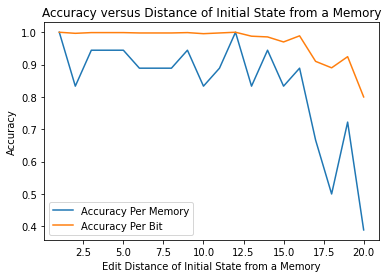

In [ ]:
plt.plot(distances, boolean_accuracy, label = "Accuracy Per Memory")
plt.plot(distances, bit_accuracy, label = "Accuracy Per Bit")
plt.legend()
plt.title("Accuracy versus Distance of Initial State from a Memory")
plt.xlabel("Edit Distance of Initial State from a Memory")
plt.ylabel("Accuracy")
plt.show()